In [1]:
%pylab inline
import sys

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp


import matplotlib.pyplot as plt

sys.path.append('../')
from mederrata_spmf import SparsePoissonLinearFactorization


Populating the interactive namespace from numpy and matplotlib


# Generate a count matrix of random noise

We want our factor model to tell us that this is just noise

In [2]:
N = 50000
# Test taking in from tf.dataset, don't pre-batch
data = tf.data.Dataset.from_tensor_slices(
    {
        'data': np.random.poisson(3.0, size=(N, 20)),
        'indices': np.arange(N),
        'normalization': np.ones(N)
    })

data = data.batch(1000)


Currently, the input data has to be in this format, as a tensorflow BatchDataset object with the given key/values.

# Set up the inference object

In [3]:
# strategy = tf.distribute.MirroredStrategy()
strategy = None
factor = SparsePoissonLinearFactorization(
    data, latent_dim=5, auxiliary_horseshoe=True, strategy=strategy,
    dtype=tf.float64)
# Test to make sure sampling works


Feature dim: 20 -> Latent dim 5


## Test out the prior distributions

In [4]:
## 
sample = factor.joint_prior.sample()
# Compute the joint log probability of the sample
probs = factor.joint_prior.log_prob(sample)
sample_surrogate = factor.surrogate_distribution.sample(77)
probs_parts = factor.unormalized_log_prob_parts(
    **sample_surrogate, data=next(iter(data)))
prob = factor.unormalized_log_prob(
    **sample_surrogate,  data=next(iter(data)))



# Inference

In [5]:
losses = factor.calibrate_advi(
    num_epochs=100, rel_tol=1e-4, learning_rate=.1)



W0515 10:40:43.810310 4542135744 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Initial loss: 111.96435768663092
Epoch 1: average-batch loss: 43.120191026105246 last batch loss: 36.58952006428015
Saved a checkpoint: ./.tf_ckpts/chkpt-1
Epoch 2: average-batch loss: 35.93311702173478 last batch loss: 35.402746237288056
Saved a checkpoint: ./.tf_ckpts/chkpt-2
Epoch 3: average-batch loss: 35.09302647148133 last batch loss: 34.7978280072611
Saved a checkpoint: ./.tf_ckpts/chkpt-3
Epoch 4: average-batch loss: 34.71109778273464 last batch loss: 34.518217574941914
Saved a checkpoint: ./.tf_ckpts/chkpt-4
Epoch 5: average-batch loss: 34.43827305653817 last batch loss: 34.275562127851344
Saved a checkpoint: ./.tf_ckpts/chkpt-5
Epoch 6: average-batch loss: 34.18393317984185 last batch loss: 34.080722386211114
Saved a checkpoint: ./.tf_ckpts/chkpt-6
Epoch 7: average-batch loss: 34.03348935558909 last batch loss: 34.00763003114165
Saved a checkpoint: ./.tf_ckpts/chkpt-7
Epoch 8: average-batch loss: 33.94323343937578 last batch loss: 33.89395443719289
Saved a checkpoint: ./.tf_c

Epoch 66: average-batch loss: 33.36632895556181 last batch loss: 33.34262665874449
Epoch 67: average-batch loss: 33.364117973544495 last batch loss: 33.34327205728802
Saved a checkpoint: ./.tf_ckpts/chkpt-56
Epoch 68: average-batch loss: 33.36366106040221 last batch loss: 33.333005470061806
Saved a checkpoint: ./.tf_ckpts/chkpt-57
Epoch 69: average-batch loss: 33.360134110529984 last batch loss: 33.34986310704229
Saved a checkpoint: ./.tf_ckpts/chkpt-58
Epoch 70: average-batch loss: 33.35841459892867 last batch loss: 33.34265637502846
Saved a checkpoint: ./.tf_ckpts/chkpt-59
Epoch 71: average-batch loss: 33.36206054764833 last batch loss: 33.33655712065018
We are in a loss plateau learning rate: 9.765625e-05 loss: 33.62776098044804
Restoring from a checkpoint - loss: 33.63097215793381
Epoch 72: average-batch loss: 33.36143837999945 last batch loss: 33.341884187152196
Epoch 73: average-batch loss: 33.36238836483071 last batch loss: 33.325657265122224
Epoch 74: average-batch loss: 33.364

# Compute the WAIC

In [6]:
waic = factor.waic()
print(waic)

{'waic': <tf.Tensor: shape=(), dtype=float64, numpy=1733394.733054672>, 'se': <tf.Tensor: shape=(), dtype=float64, numpy=8381.718243464487>, 'lppd': <tf.Tensor: shape=(), dtype=float64, numpy=-82641.16707466086>, 'pwaic': <tf.Tensor: shape=(), dtype=float64, numpy=784056.1994526751>}


# Plot the factor encoding matrix

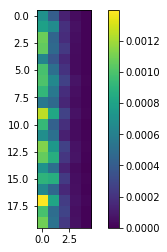

In [9]:
plt.imshow(factor.encoding_matrix(), vmin=0)
plt.colorbar()
plt.show()


The values in the factor encoding matrix as near zero. There is a gradient because the model induces a dimensional decay to remove symmetries - this encourages the leading dimensions to hold more of the signal.

# Plot the intercept matrix

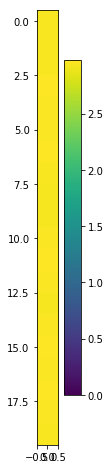

In [17]:
fig = plt.figure(figsize=(2,8))
plt.imshow(factor.intercept_matrix().numpy().T, vmin=0)
plt.colorbar()
plt.show()


Most of the signal loads into the intercept at a value near 3, which is what we want!